New model

In [1]:
# ---- import modules ----------------------------------------------------------------------------------------------
# to see graph 
%matplotlib inline                                    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import itertools
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.optimize import leastsq
import matplotlib.gridspec as gridspec

In [ ]:
brand = 'PSA'
folder= '../Docs/Scoring/Scoring_'+brand+'/'
name3 = folder+'Scoring_'+brand+'_2010.csv'
name4 = folder+'Scoring_'+brand+'_2011.csv'
name5 = folder+'Scoring_'+brand+'_2012.csv'
name6 = folder+'Scoring_'+brand+'_2013.csv'
name7 = folder+'Scoring_'+brand+'_2014.csv'
name8 = folder+'Scoring_'+brand+'_2015.csv'
name9 = folder+'Scoring_'+brand+'_2016.csv'
name10= folder+'Scoring_'+brand+'_2017.csv'

In [36]:
df_list = [name3, name4, name5, name6, name7, name8, name9, name10 ]
t = []
for i in df_list:

    df_name = pd.read_csv(i+'.gz',sep=';',compression='gzip')
    t.append(df_name)
    print('The dataframe {} contains {} rows'.format( i, len(df_name))
df = pd.concat(t, axis=0)
#df_fin.to_csv('PSA_histo.csv.gz', sep=';',compression='gzip')

SyntaxError: invalid syntax (<ipython-input-36-75adead03f01>, line 8)

In [4]:
def func_treatment(data, head, year): # , col

    pd.options.mode.chained_assignment = None                       # permit to avoid error in copying 
    
    #cols = col 
    #for c in cols:
    #    data[c] = pd.to_numeric(data[c], errors='coerce')           # cast the type str to numeric
        
    # Select a part of the dataframe where the year is > at year passed in the function 
    data = data[(data['Annee'].astype(int)<=datetime.now().year) & (data['Annee'].astype(int)>=year) ]
    #data = data[data[head[4]]>0]
    date = [datetime(data['Annee'].iat[i],data['Mois'].iat[i],1) for i in range(len(data))]
    data['Date'] = date                                             # .astype() permit to cast a type to another     
                                                                    # passed in the () 
    # ---- Create the age to compare --------------------------------    
    #print(data.data_month[:5])
    if(len(data)>0):
        test=data.data_month.iat[0].split('_')
        test2=data.data_month.iat[0].split('/')
        if(len(test)>1):
            data_month = [i.split('_') for i in data.data_month.values]
            data_month = [datetime(int(i[0]),int(i[1]),1) for i in data_month]          # make a datetime
        else:
            if(len(test2)):
                data_month = [i.split('/') for i in data.data_month.values]
                data_month = [datetime(int(i[2]),int(i[1]),int(i[0])) for i in data_month] 
            #data_month = [i.split('-') for i in data.data_month.values]
            else:
                data_month = parse(data.data_month)
        #print('third',data_month[:5])
    #print (data_month[:5])
    else:
        data_month = []
    
    date_age=[round((data_month[i]-date[i]).days/30) for i in range(len(date))] # compute the age in months
    
    data['Age_months']=date_age                                                 # save in a new column
    data = data[data.Age_months>=0]                                             # keep all positive or null age 
    # ---- Data cleaning --------------------------------------------
    a = data[head[0]].fillna(' ')
    data[head[0]] = a.values
    a = data[head[1]].apply(lambda x : x if x>0 else 0 )
    data[head[1]] = a.values    
    return data

def func_outliers(data):                                       # remove outliers from data
    data=data[data.Prix<100000]
    data=data[data.Prix>500]
    years = data['Annee'].unique()                             # list of years unique
    years = list(years)
    years.sort()                                               # sort the list ascending
    t = []
    if(len(years)<3):                                          # if we have 1 or 2 years we take all the data
        return data
    for i in years :
        df = data[data['Annee']==i]                            # select a subdataframe by year
        months = df['Mois'].unique()                          # return a list of month
        for j in months:
            df2 = df[df['Mois']==j]                           # select a subsubdataframe by month in the year
            mean = df2['Prix'].median(axis=0)                 # compute the median of the price for the month
            std  = df2['Prix'].std(axis=0)                    # compute the standard deviation
            df_fin = df2[(df2['Prix'] < (mean+ 3* std)) ]     # select price in the interval median+/-2std
            df_fin = df_fin[(df_fin['Prix']>(mean-3*std))]
            t.append(df_fin)                                   # create a list of subsubdataframe
        d = pd.concat(t, axis=0)                               # create a final dataframe of the points without 
                                                               # outliers
    d = d.drop_duplicates(d[['Prix','KM','Date']],keep='last')
    return d

def func_mean_median(data, name):
    # ---- Mean Median computation --------------------------
    mean     = []                                # Empty list to stock the results of the computation
    median   = []
    err      = []
    km_value = []
    months   = []
    for i in data[name].unique():
        d  = data[data[name]==i]                # Select a subdataframe by date
        z  = d['Prix'].mean(axis=0)            # Compute the mean of the price
        z4 = d['Prix'].std(axis=0)             # Compute the standard deviation of the price 
        z2 = d['Prix'].median(axis=0)          # Compute the median of the price
        z3 = d['KM'].mean(axis=0)            # Compute the mean of the kilometer
        #months.append(d.Age_months.mean(0))    # Save the corresponding month
        mean.append(z)                          # Save the values in the lists 
        median.append(z2)
        err.append(z4)
        km_value.append(z3)
    # ---- Save the results in a dictionnary --------------------------------------------------------------------------
    dict_values = { name       :pd.Series(np.array(data[name].unique())),
                   'Mean'      :pd.Series(np.array(mean)),
                   'Median'    :pd.Series(np.array(median)),
                   'Error'     :pd.Series(np.array(err)),
                   'km'        :pd.Series(np.array(km_value))}#,
                   #'Age_months':pd.Series(np.array(months))}
    # Pass from dict to dataframe by specifying the name of the columns - correspond to the columns' order
    df_results = pd.DataFrame(columns = [name, 'Mean','Median','Error','km'],data=dict_values)
    return df_results


# ---- Functions for the different fits -------------------------------------------------------------------------------
def func_fitexp(x, y):                                      # fit exponential with numpy package   
    res = np.polyfit(x, np.log(y), 1,w=np.sqrt(y))
    res_tot = np.exp(res[1])*np.exp(res[0]*x)
    return res_tot, res

def func_exp(x, y):                                         # fit exponential with scipy package 
    res_fit = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(20000, 1e-6))
    #print(res_fit[0])
    return res_fit[0][0] * np.exp(res_fit[0][1] * x)

def func_exp2(p, x, z):                                     # exponential function with multiple parameters  
#    a, b, t, t2 = p[0], p[1], p[2], p[3]
    a, b, c, d, t, t2 = p[0], p[1], p[2], p[3], p[4], p[5]
#    return a*np.exp(b + x*t + z*t2)
    return a*np.exp(b + pow(x,c)*t + pow(z,d)*t2)

def err(p, x,z, y):                                         # error function compare the previous to the estimate to
    return func_exp2(p, x,z) - y                            # minimise the residuals 

def func_poly(p, x, z):                                     # polynomial function with multiple parameters
    a, t, t2, t3, t4, t5, t6 = p[0], p[1], p[2], p[3], p[4], p[5], p[6]
    return a + x*t+ z*t2 + pow(x,2)*t3 + pow(z,2)*t4 + pow(x,3)*t5 + pow(z,3)*t6

def err_poly(p, x,z, y):                                    # error function compare the previous to the estimate to
    return func_poly(p, x,z) - y                            # minimise the residuals 

def func_annual_devalo3(y):
    devalo = y / y.shift(+1)
    #print(y[:10])
    #print(devalo[:10])
    devalo_mean= []
    x_mean = []
    i = 0
    #annee_max = np.arange(round(data.Age_months.max()/12))
    #print(annee_max)
    while i < len(y) :
        devalo_mean.append(100-100*pow(devalo[i:i+12].mean(), 12))
        i+=12
        x_mean.append(i)
    return devalo_mean, x_mean

In [5]:
#def func_mmcclbp(data, mmcclbp):
#    data = data[['Marque', 'Modele','Carrosserie', 'Carburant', 'Litre','Puissance','doublon_id_2', 'Nom',  \
#                 'Annee', 'Mois', 'Age','KM', 'Prix', 'Cote_VO', 'Ecart_prix_cote', 'site', '4RM', 'Porte', \
#                 'Couleur',  'data_month']]
#    head = list(data)
    #data = data[data['Mois'].astype(int)>0]         # keep rows with month > 0 
    #data = data[data['Mois'].astype(int)<=12]       # keep rows with month < 13
#    data = data.sort_values(by='data_month')            # sort the dataframe by the data_month (extraction)
#    j=0
#    for i in mmcclbp:
#        if i is not None:
#            if head[j] is not 'Litre':
#                data = data[data[head[j]]==i]
#            else:
#                data = data[data[head[j]].astype(float)==float(i)]
#        j+=1
#    return data

def func_mmcclbp2(test, mmcclbp):
    try:
        test = df[(df['Marque']==mmcclbp[0]) & (df['Modele']==mmcclbp[1]) &(df['Carrosserie']==mmcclbp[2]) &\
          (df['Carburant']==mmcclbp[3]) & (df['Litre']==float(mmcclbp[4])) &(df['Puissance']==mmcclbp[5]) ]
    except:
        try:
            test = df[(df['Marque']==mmcclbp[0]) & (df['Modele']==mmcclbp[1]) &(df['Carrosserie']==mmcclbp[2]) &\
          (df['Carburant']==mmcclbp[3]) & (df['Litre']==float(mmcclbp[4]))]
        except:
            try:
                test = df[(df['Marque']==mmcclbp[0]) & (df['Modele']==mmcclbp[1]) &(df['Carrosserie']==mmcclbp[2]) &\
          (df['Carburant']==mmcclbp[3])]
            except:
                try:
                    test = df[(df['Marque']==mmcclbp[0]) & (df['Modele']==mmcclbp[1]) &(df['Carrosserie']==mmcclbp[2])]
                except:
                    try:
                        test = df[(df['Marque']==mmcclbp[0]) & (df['Modele']==mmcclbp[1])]
                    except:
                        try:
                            test = df[(df['Marque']==mmcclbp[0])]
                        except:
                            print('Empty data frame')
    return test

In [6]:
name = ['data_month', 'doublon_id_2', 'Marque', 'Modele', 'Nom', 'Carburant', 'Carrosserie', 'Annee', 'Mois', 'Age',\
         'KM', 'Prix', 'Cote_VO', 'Ecart_prix_cote', 'site', '4RM', 'Porte', 'Couleur', 'Litre', 'Puissance']
df = pd.read_csv('../Histo_2010_2017.csv.gz', sep=';', compression = 'gzip', header=0, names=name)

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [289]:
name = ['data_month', 'doublon_id_2', 'Marque', 'Modele', 'Nom', 'Carburant', 'Carrosserie', 'Annee', 'Mois', 'Age',\
         'KM', 'Prix', 'Cote_VO', 'Ecart_prix_cote', 'site', '4RM', 'Porte', 'Couleur', 'Litre', 'Puissance']
df2 = pd.read_csv('../Docs/Scoring/Scoring_PSA/Scoring_PSA_2016.csv.gz', sep=';', compression = 'gzip', header=0, names=name)

In [290]:
df = df[(df['Mois']>0) & (df['Mois']<=12)]

In [291]:
df2 = df2[(df2['Mois']>0) & (df2['Mois']<=12)]
print(len(df2))

2003640


In [292]:
#mmcclbp = ['DS AUTOMOBILES','DS5', 'BERLINE', 'DIESEL', '2.0',163]
mmcclbp = ['DS AUTOMOBILES','DS5', 'BERLINE', 'DIESEL', '2.0',181]
df = df2 
print(df[['Modele','Carrosserie','Carburant','Litre', 'Puissance']][df['Modele']=='DS5'].drop_duplicates())

        Modele Carrosserie            Carburant  Litre  Puissance
212        DS5     BERLINE  DIESEL - ELECTRIQUE    0.0          0
213        DS5     BERLINE  DIESEL - ELECTRIQUE    2.0        166
279        DS5     BERLINE               DIESEL    0.0          0
333        DS5     BERLINE               DIESEL    2.0          0
344        DS5     BERLINE               DIESEL    1.6        120
689        DS5     BERLINE               DIESEL    0.0        111
712        DS5     BERLINE  DIESEL - ELECTRIQUE    2.0        163
1666       DS5     BERLINE              ESSENCE    0.0          0
1708       DS5     BERLINE               DIESEL    0.0        136
1839       DS5     BERLINE  DIESEL - ELECTRIQUE    2.0        200
1902       DS5     BERLINE               DIESEL    1.6        115
2910       DS5     BERLINE           ELECTRIQUE    0.0          0
3212       DS5     BERLINE               DIESEL    2.0        180
4811       DS5     BERLINE               DIESEL    0.0        160
5538      

In [293]:
%time df6 = func_mmcclbp2(df, mmcclbp)

CPU times: user 1.03 s, sys: 42 ms, total: 1.07 s
Wall time: 1.11 s


In [294]:
%time
try:
    test = df[(df['Marque']==mmcclbp[0]) & (df['Modele']==mmcclbp[1]) &(df['Carrosserie']==mmcclbp[2]) &\
          (df['Carburant']==mmcclbp[3]) & (df['Litre']==float(mmcclbp[4])) &(df['Puissance']==mmcclbp[5]) ]
except:
    try:
        test = df[(df['Marque']==mmcclbp[0]) & (df['Modele']==mmcclbp[1]) &(df['Carrosserie']==mmcclbp[2]) &\
          (df['Carburant']==mmcclbp[3]) & (df['Litre']==float(mmcclbp[4]))]
    except:
        try:
            test = df[(df['Marque']==mmcclbp[0]) & (df['Modele']==mmcclbp[1]) &(df['Carrosserie']==mmcclbp[2]) &\
          (df['Carburant']==mmcclbp[3])]
        except:
            try:
                test = df[(df['Marque']==mmcclbp[0]) & (df['Modele']==mmcclbp[1]) &(df['Carrosserie']==mmcclbp[2])]
            except:
                try:
                    test = df[(df['Marque']==mmcclbp[0]) & (df['Modele']==mmcclbp[1])]
                except:
                    try:
                        test = df[(df['Marque']==mmcclbp[0])]
                    except:
                        print('Empty data frame')
print(len(test))

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 13.1 µs
1834


In [295]:
test = test[test['KM']<70000]

In [296]:
print(len(test))

1767


In [297]:
%time
test2 = func_mmcclbp2(df,mmcclbp)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [298]:
%time 
df_model = func_treatment(test, list(test), 2000)
#if (len(df_model)>1000):
#    df_model = func_outliers(df_model)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


In [299]:
print(df_model[['Modele','Carburant','Carrosserie','Age_months','KM','Prix']].head())
print(len(df_model))

       Modele Carburant Carrosserie  Age_months     KM   Prix
635233    DS5    DIESEL     BERLINE          20   9539  27491
638731    DS5    DIESEL     BERLINE          32  54240  24490
639315    DS5    DIESEL     BERLINE          16  21000  27999
667288    DS5    DIESEL     BERLINE           9   8500  39990
669484    DS5    DIESEL     BERLINE          14  32379  27990
1767


In [300]:
df_results = func_mean_median(df_model, 'Age_months')

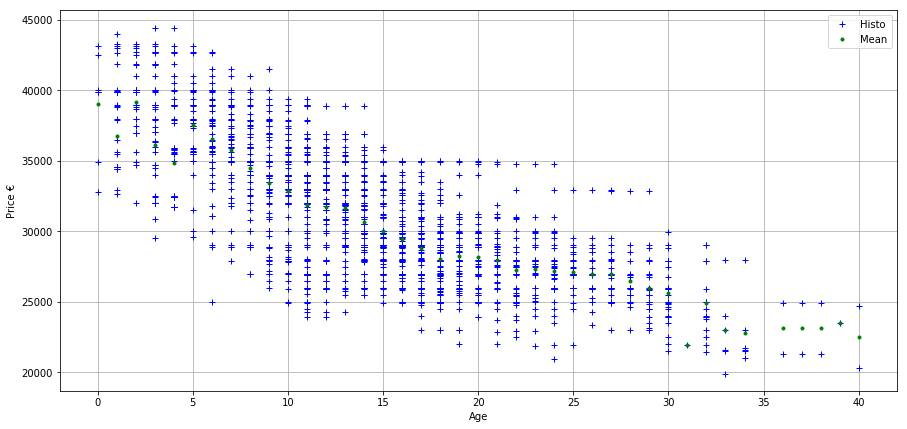

In [301]:
# Comparaison between the last year (2017) and the all datasets 
fig = plt.figure(figsize=(15,7))                                           # size of the figure
# ---- Year : 2017 ----------------------------------------------------------------------------------------------------
plt.plot(df_model.Age_months, df_model.Prix, 'b+', label='Histo')     # plot of the mean
plt.plot(df_results.Age_months, df_results.Mean, 'g.', label='Mean') # plot of the median

# ---- All data -------------------------------------------------------------------------------------------------------
#plt.plot(df_histo.Age_months, df_histo.Mean, '.', label='Median histo')    # plot the mean of all the data 
plt.legend()
#plt.title('model')
plt.xlabel('Age')
plt.ylabel('Price €')
plt.grid(True)

In [302]:
p1=[20000,-1e-3,1,1,1,-1e-2, -1e-6]
df_fit = df_model
df_fit = df_fit.sort_values('Age_months')
param, ier = leastsq(err_poly, p1, args=(df_fit.Age_months,df_fit.KM,\
                                         df_fit.Prix), maxfev=50000000)
print(param)
p0=[param[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
param_exp, ier = leastsq(err, p0, args=(df_fit.Age_months,df_fit.KM,df_fit.Prix), maxfev=5000000)

p2=[param[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
pfit, pcov, infodict, errmsg, success = leastsq(err, p2, args=(df_fit.Age_months,df_fit.KM,\
                                                               df_fit.Prix), full_output=1, epsfcn=0.00001)
pfit_fin, pcov, infodict, errmsg, success = leastsq(err, pfit, args=(df_fit.Age_months,df_fit.KM,\
                                                                 df_fit.Prix), full_output=1, epsfcn=0.000001)

print(param_exp, ier)
print(pfit_fin)

y = func_exp2(param_exp, df_fit.Age_months,df_fit.KM)   # values of the price with the model
y_2= func_exp2(pfit_fin, df_fit.Age_months,df_fit.KM)        # values of the price with the model
y_3= func_poly(param, df_fit.Age_months,df_fit.KM)
df_fit['New_price']=y_2
df_fit['Shift']=y_2/y_2.shift(+1)


[  3.86551602e+04  -6.38614039e+02   1.34236211e-02   1.32551585e+01
  -5.04965637e-06  -1.07876406e-01   5.57542274e-11]


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:115: RuntimeWarning: overflow encountered in exp


[  3.85355094e+04   1.12274117e-02   7.64122143e-01   1.26873894e+00
  -2.40966680e-02  -1.96872822e-07] 1
[  3.92172272e+04  -6.28278413e-03   7.63892068e-01   1.27019414e+00
  -2.41231741e-02  -1.93755477e-07]


In [303]:

#print(df_fit.Age_months, df_fit.Prix)


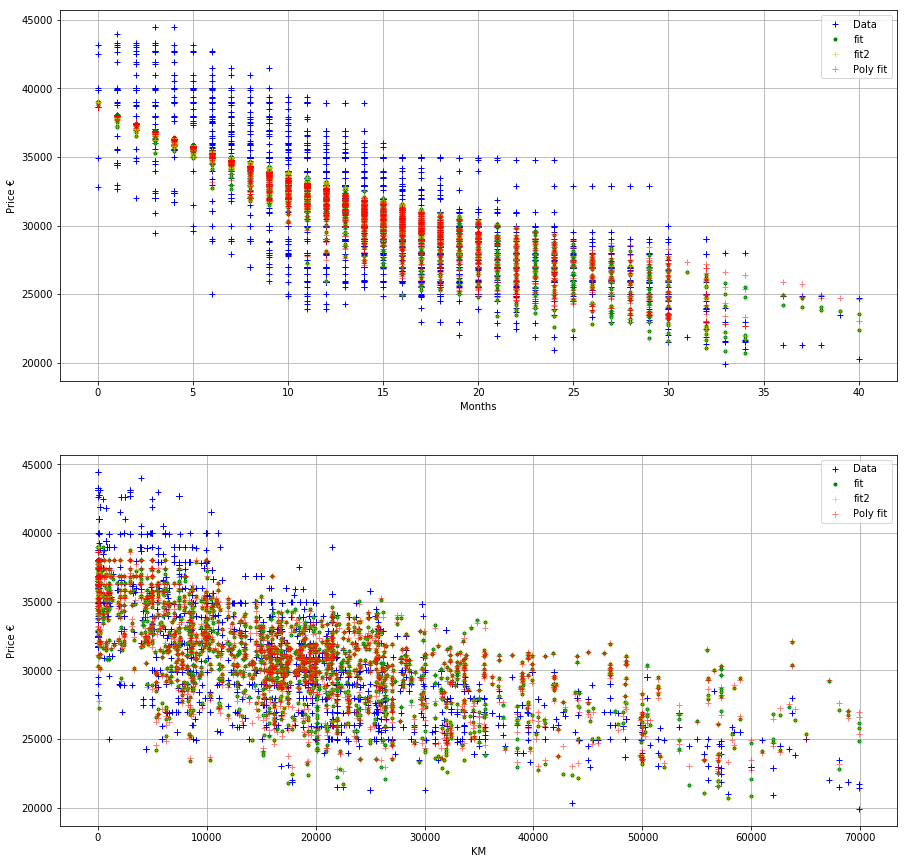

In [304]:
df_fit = df_fit.sort_values('Age_months')
fig = plt.figure(figsize=(15,15))                                            # size of the all picture
ax1 = plt.subplot(211)                                                     # first subplot 1/4 
plt.plot(df_fit.Age_months, df_fit.Prix, 'b+', alpha=1,label='Data') # All the data, plot price = f(age)
plt.plot(df_fit.Age_months, y, 'g.', label='fit')              # Fit of the all data 
plt.plot(df_fit.Age_months, y_2, 'y+',alpha=0.5, label='fit2')           # Fit of the all data 

plt.plot(df_fit.Age_months, y_3, 'r+',alpha=0.5, label='Poly fit')           # Fit of the all data 

#plt.ylim(-1000,np.amax(y_New)+10000)                           # resize the figure 
plt.legend()
#plt.title(model)
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)
ax2 = plt.subplot(212)                                                     # first subplot 1/4 
plt.plot(df_fit.KM, df_fit.Prix, 'b+', alpha=1,label='Data') # All the data, plot price = f(age)
plt.plot(df_fit.KM, y, 'g.', label='fit')              # Fit of the all data 
plt.plot(df_fit.KM, y_2, 'y+',alpha=0.5, label='fit2')           # Fit of the all data 

plt.plot(df_fit.KM, y_3, 'r+',alpha=0.5, label='Poly fit')           # Fit of the all data 

plt.legend()
#plt.title(model)
plt.xlabel('KM')
plt.ylabel('Price €')
plt.grid(True)

In [305]:
p1=[20000,-1e-3,1,1,1,-1e-2, -1e-6]
df_fit = df_results
df_fit = df_fit.sort_values('Age_months')
param, ier = leastsq(err_poly, p1, args=(df_fit.Age_months,df_fit.km,\
                                         df_fit.Mean), maxfev=5000000)
print(param)
p0=[param[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
param_exp, ier = leastsq(err, p0, args=(df_fit.Age_months,df_fit.km,df_fit.Mean), maxfev=500000)

p2=[param[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
pfit, pcov, infodict, errmsg, success = leastsq(err, p2, args=(df_fit.Age_months,df_fit.km,\
                                                               df_fit.Mean), full_output=1, epsfcn=0.000001)
pfit_fin, pcov, infodict, errmsg, success = leastsq(err, pfit, args=(df_fit.Age_months,df_fit.km,\
                                                                 df_fit.Mean), full_output=1, epsfcn=0.0000001)

print(param_exp, ier)
print(pfit_fin)

y = func_exp2(param_exp, df_fit.Age_months.values,df_fit.km.values)   # values of the price with the model
y_2= func_exp2(pfit_fin, df_fit.Age_months.values,df_fit.km.values)        # values of the price with the model
df_fit['New_price']=y_2
#df_fit['Shift']=y_2/y_2.shift(+1)
#print(y_2)
y_3 = func_exp2(pfit_fin, df_model.Age_months.values,df_model.KM.values) 

[  3.92496094e+04  -5.99202951e+02  -1.60419259e-01  -3.11664684e+00
   1.21209554e-05   1.73794894e-01  -1.72729677e-10]
[  3.94392841e+04  -2.17169814e-03   8.40773491e-01   1.05378532e+00
  -2.58894698e-02  -5.17341914e-08] 1
[  3.92864310e+04   1.70766120e-03   8.40787614e-01   1.05513202e+00
  -2.58883841e-02  -5.09032164e-08]


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:115: RuntimeWarning: overflow encountered in exp


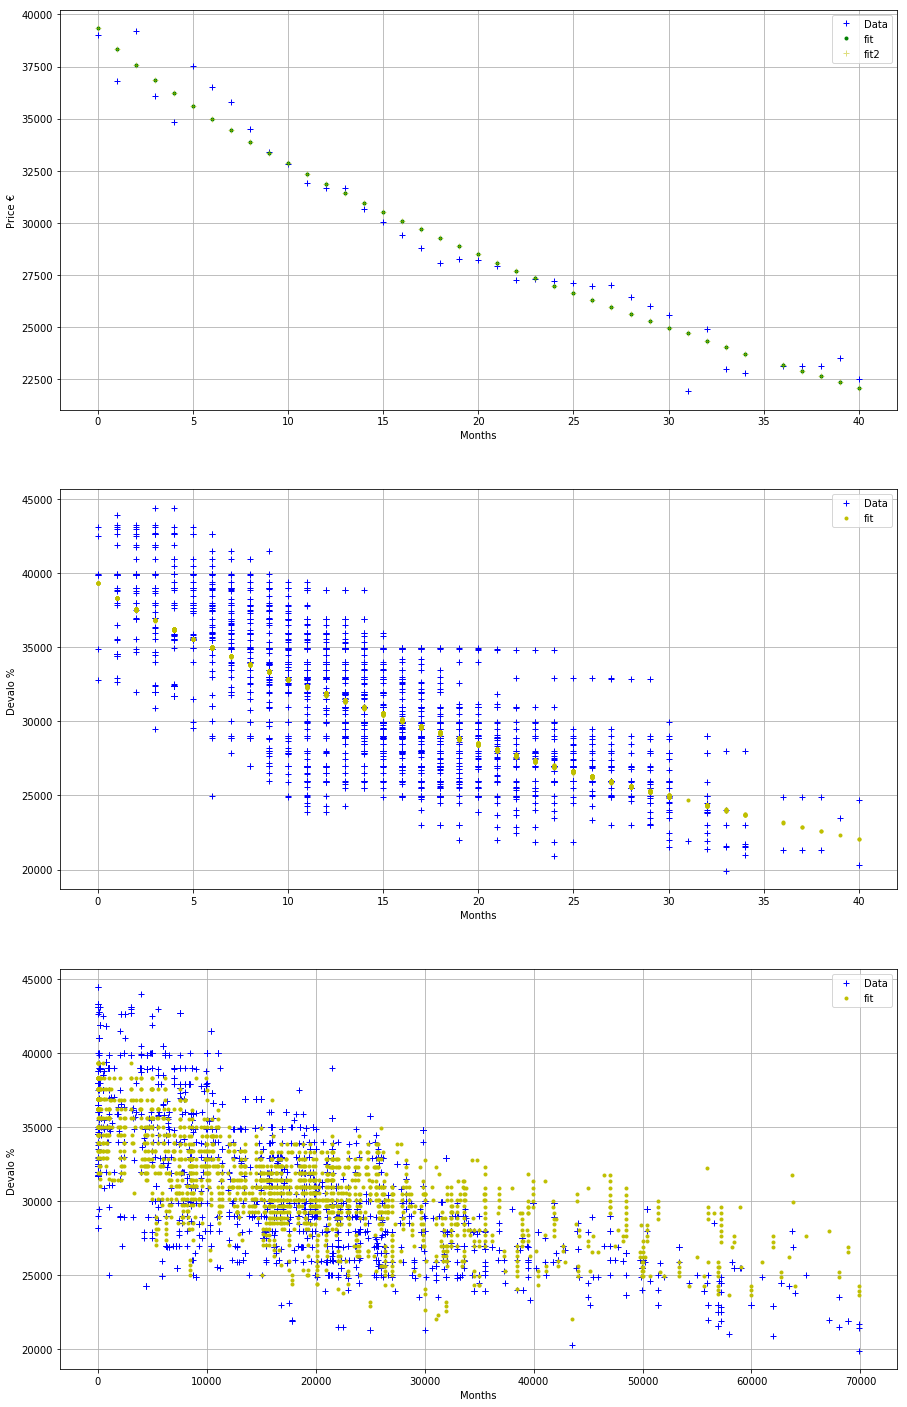

In [306]:

fig = plt.figure(figsize=(15,25))                                            # size of the all picture
ax1 = plt.subplot(311)                                                     # first subplot 1/4 
plt.plot(df_fit.Age_months.values, df_fit.Mean.values, 'b+', alpha=1,label='Data') # All the data, plot price = f(age)
plt.plot(df_fit.Age_months.values, y, 'g.', label='fit')              # Fit of the all data 
plt.plot(df_fit.Age_months.values, y_2, 'y+',alpha=0.5, label='fit2')           # Fit of the all data 
#plt.ylim(-1000,np.amax(y_New)+10000)                           # resize the figure 
plt.legend()
#plt.title(model)
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)
ax2 = plt.subplot(312)                                                     # first subplot 1/4 
plt.plot(df_model.Age_months.values, df_model.Prix.values, 'b+', alpha=1,label='Data') # All the data, plot price = f(age)
plt.plot(df_model.Age_months.values, y_3, 'y.', label='fit')              # Fit of the all data 
plt.legend()
#plt.title(model)
plt.xlabel('Months')
plt.ylabel('Devalo % ')
plt.grid(True)
ax3 = plt.subplot(313)                                                     # first subplot 1/4 
plt.plot(df_model.KM.values, df_model.Prix.values, 'b+', alpha=1,label='Data') # All the data, plot price = f(age)
plt.plot(df_model.KM.values, y_3, 'y.', label='fit')              # Fit of the all data 
plt.legend()
#plt.title(model)
plt.xlabel('Months')
plt.ylabel('Devalo % ')
plt.grid(True)

In [307]:
del df_model

In [308]:
del test

In [309]:
del df_fit